In [1]:
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *

/home/jonathon/projects/mothman/Kernels/Kernels.py:364: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if (boundary is not 'upper') & (boundary is not 'lower'):
/home/jonathon/projects/mothman/Kernels/Kernels.py:364: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if (boundary is not 'upper') & (boundary is not 'lower'):


In [ ]:
class FluidRelation:
  def __init__(self, cp: float, mu: float, k: float, rho_0: float, drho_dT: float):
    self.cp = cp
    self.mu = mu
    self.k = k
    self.rho_0 = rho_0 # example 2715.13 - 0.513 * T[K] ---> rho_eos = [2715.13, -0.513] -> rho_0 = 2715.13 ; drho_dT = -0.513
    self.drho_dT = drho_dT
  def props_from_P_H(self, P: float, enthalpy: float, prop: str):
    # First get temperature from pressure and enthalpy
    _T = enthalpy / self.cp # ok
    if prop == 'T':
      return _T
    elif prop == 'rho':
      return self.rho_0 + self.drho_dT * _T
    else:
      raise Exception("Requested property not available")

  def props_from_P_T(self, P:float, T:float, prop: str):
    if prop == 'h':
      return self.cp*T
  def get_mu(self):
    return self.mu

class Channel:
  def __init__(self, gravity: float,
               Dh: float,
               area: float,
               temp_tolerance: float,
               max_temp_iterations: int,
               nZones: int,
               L0: float,
               L1: float,
               fluid: FluidRelation,
               pressure_bc: float,
               T_bc: float,
               mdot_bc: float,
               fric: str):
    # Initial data that remains constant for this channel during the simulation.
    self.gravity = gravity
    self.Dh = Dh
    self.area = area
    self.temp_tolerance = temp_tolerance
    self.nZones = nZones
    self.L0 = L0
    self.L1 = L1
    self.fluid = fluid
    self.fric = fric

    # Make a mesh
    coords = np.linspace(L0,L1,nZones)
    areas = [area]*nZones
    self.mesh = Mesh_1D(nodeCoords=coords, faceAreas=
                        areas)

    # Set boundary conditions
    self.set_bcs(pressure_bc=pressure_bc, T_bc=T_bc, mdot_bc=mdot_bc)

    # Make some variables
    self.pressure = ScalarField(name='P', initial_value=self.pressure_bc, mesh=self.mesh)
    self.mdot = ScalarField(name='mdot', initial_value=self.mdot_bc, mesh=self.mesh)
    self.h = ScalarField(name='enthalpy', initial_value=self.T_bc, mesh=self.mesh)
    self.rho = ScalarField(name='density', initial_value=self.rho_bc, mesh=self.mesh)
    self.temp = ScalarField(name='temp', initial_value=self.T_bc, mesh=self.mesh)

    # Make some matrices and vectors
    self.A_mass = np.zeros([self.mesh.nz, self.mesh.nz])
    self.A_energy = np.zeros([self.mesh.nz, self.mesh.nz])
    self.A_momentum = np.zeros([self.mesh.nz, self.mesh.nz])
    self.b_mass = np.zeros([self.mesh.nz])
    self.b_energy = np.zeros([self.mesh.nz])
    self.b_momentum = np.zeros([self.mesh.nz])

    # Channel conditions dictionary:
    self.channel_conditions = {}
    self.channel_conditions['dP'] = None
    self.channel_conditions['P_out'] = None
    self.channel_conditions['P_in'] = None
    self.channel_conditions['h_out'] = None
    self.channel_conditions['h_in'] = None
    self.channel_conditions['mdot_out'] = None
    self.channel_conditions['mdot_in'] = None

  def get_friction_factor(self, Reynolds: float):
    # Friction  factors for a channel from the thesis Luzzi et al., 2010
    if self.fric == 'type1':
      if Reynolds > 3000:
        return 0.3164 / Reynolds**0.25 * (1.0 + Reynolds/4.31e5)**(1.0/8.0)
      elif Reynolds <= 3000:
        return 64.0 / Reynolds
    # Unknown!
    else:
      raise Exception("Friction factor type unknown!")

  def set_bcs(self, pressure_bc: float, T_bc: float, mdot_bc: float):
    """
    Sets boundary conditions for the pressure, temperature, and mdot.
    """
    self.pressure_bc = pressure_bc
    self.T_bc = T_bc
    self.mdot_bc = mdot_bc
    self.h_bc = self.fluid.props_from_P_T(P=self.pressure_bc, T=self.T_bc, prop='h')
    self.rho_bc = self.fluid.props_from_P_H(P=self.pressure_bc, enthalpy=self.h_bc, prop='rho')

  # MASS EQUATION
  def solve_mass_equation(self, _dt: float):
    mesh = self.mesh
    """
    MASS EQUATION AND SETUP
    """
    for cid in mesh.cidList:
      area = ( mesh.cells[cid].upperArea + mesh.cells[cid].lowerArea ) / 2.0
      dz = mesh.cells[cid].dz
      A_X_dt = area*dz / _dt

      # Solve implicitely for mass flow rates based on densities
      ### A_X_dt * (rho - rho_old) + (m - m_i-1) = 0.0
      self.b_mass[cid] =  -1.0 * A_X_dt * (self.rho.T[cid] - self.rho.T_old[cid])
      self.A_mass[cid,cid] = 1.0
      if cid == 0: # Boundary
        self.b_mass[cid] += self.mdot_bc
      else:
        self.A_mass[cid,cid-1] = -1.0

    # SOLVE
    self.mdot.T = np.linalg.solve(self.A_mass, self.b_mass)

  # ENERGY EQUATION
  def solve_energy_equation(self, _dt: float):
    mesh = self.mesh
    """
    ENERGY EQUATION AND SETUP
    """
    for cid in mesh.cidList:
      # Geometry stuff
      area = ( mesh.cells[cid].upperArea + mesh.cells[cid].lowerArea ) / 2.0
      dz = mesh.cells[cid].dz
      # main diagonal
      self.A_energy[cid,cid] = area/_dt * (self.rho.T[cid] - self.rho.T_old[cid]) + 1.0/dz * self.mdot.T[cid]

      # off diagonal coeff for enthalpy
      if cid == 0:
        self._energy[cid] += 1.0/dz * self.mdot_bc * self.h_bc
      else:
        self.A_energy[cid,cid-1] = -1.0/dz * self.mdot.T[cid-1]

    # SOLVE
    self.h.T = np.linalg.solve(self.A_energy, self.b_energy)

  # PRESSURE EQUATION
  def solve_pressure_equation(self, _dt: float):
    mesh = self.mesh

    """
    MOMENTUM EQUATION AND SETUP
    """
    for cid in mesh.cidList:
      # geometry stuff
      area = ( mesh.cells[cid].upperArea + mesh.cells[cid].lowerArea ) / 2.0
      dz = mesh.cells[cid].dz

      # main diagonal
      self.A_momentum[cid, cid] = area

      # off diagonal
      if cid == 0:
        self.b_momentum[cid] = self.pressure_bc*area
      else:
        self.A_momentum[cid,cid-1] = -1.0*area

      # compute friction factor
      Reynolds = self.mdot.T[cid] * self.Dh * self.rho.T[cid] / self.fluid.get_mu()
      _fric = self.get_friction_factor(Reynolds=Reynolds)

      # additional b terms
      self.b_momentum[cid] += (
            -1.0 * self._gravity*area*dz*self.rho.T[cid]) - (
            0.5 * dz * _fric/self.Dh/self.rho.T[cid] * np.abs(self.mdot.T[cid])  * self.mdot.T[cid] / area ) - (
            dz / _dt * (self.mdot.T[cid] - self.mdot.T_old[cid]) )
    self.pressure.T = np.linalg.solve(self.A_momentum, self.b_momentum)

  # EOS FOR TEMPERATURE AND DENSITY
  def solve_EOS(self):
    # New temp and density arrays
    temp_updated = np.array([])
    rho_updated = np.array([])
    for cid in self.mesh.cidList:
      t_new = self.fluid.props_from_P_H(P=self.pressure.T[cid], enthalpy=self.h.T[cid], prop='T')
      temp_updated = np.append(temp_updated, t_new)
      rho_updated = np.append(rho_updated, self.fluid.props_from_P_H(P=self.pressure.T[cid], enthalpy=self.h.T[cid], prop='rho') )

    max_diff = np.max(np.abs(self.temp.T - temp_updated))
    self.temp.T = temp_updated
    self.rho.T = rho_updated

  def update_channel_conditions(self):
    self.channel_conditions['P_out'] = self.pressure.T[-1]
    self.channel_conditions['P_in'] = self.pressure_bc
    self.channel_conditions['dP'] = self.pressure.T[-1] - self.pressure_bc
    self.channel_conditions['h_out'] = self.h.T[-1]
    self.channel_conditions['h_in'] = self.h_bc
    self.channel_conditions['mdot_out'] = self.mdot.T[-1]
    self.channel_conditions['mdot_in'] = self.mdot_bc

  # SOLVING LOOP
  def solve_channel(self, _dt: float):
    # Start loop
    iteration_num = 0
    max_diff = 1e321
    while max_diff > self.temp_tolerance:

      # Handle iteration limit
      iteration_num += 1
      if iteration_num > self.max_temp_iterations:
        raise Exception("Iteration number exceeded for this channel!")

      # Solve equations
      self.solve_mass_equation(_dt=_dt) # solves and updates mass flow rates
      self.solve_energy_equation(_dt=_dt) # solves and updates enthalpy
      self.solve_pressure_equation(_dt=_dt) # solves and updates pressures
      max_diff = self.solve_EOS() # solves and updates temperature and density - returns maximum temp diff.

    # After we solve we update our channel conditions for later reference:
    self.update_channel_conditions()






In [ ]:
# Fluid property data
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)

# some other variables
_gravity = 9.81
_fric = 64.0 / 2000.0
Dh = 0.0158276279311347000000
perim = 0.07267978843558340
area = 0.000287587162368000000
temp_tolerance = 1e-10

# initial parameters / user input
nZones = 25
areas = [area]*nZones
L0 = 0
L1 = 1.73
coords = np.linspace(L0,L1,nZones)

# time delta t
_dt = 1e321

# BCs
mdot_bc = 0.0607
pressure_bc = 0.0
T_bc = 900.0
h_bc = fluid.props_from_P_T(P=pressure_bc, T=T_bc, prop='h')
rho_bc = fluid.props_from_P_H(P=pressure_bc, enthalpy=h_bc, prop='rho')


# Make a mesh
mesh = Mesh_1D(nodeCoords=coords, faceAreas=areas)

# Make fields for each variable
pressure = ScalarField(name='P', initial_value=pressure_bc, mesh=mesh)
mdot = ScalarField(name='mdot', initial_value=mdot_bc, mesh=mesh)
h = ScalarField(name='enthalpy', initial_value=T_bc, mesh=mesh)
rho = ScalarField(name='density', initial_value=rho_bc, mesh=mesh)
temp = ScalarField(name='temp', initial_value=T_bc, mesh=mesh)

A_mass = np.zeros([mesh.nz, mesh.nz])
A_energy = np.zeros([mesh.nz, mesh.nz])
A_momentum = np.zeros([mesh.nz, mesh.nz])

b_mass = np.zeros([mesh.nz])
b_energy = np.zeros([mesh.nz])
b_momentum = np.zeros([mesh.nz])

"""
MASS EQUATION SETUP AND SOLUTION
"""
for cid in mesh.cidList:
  area = ( mesh.cells[cid].upperArea + mesh.cells[cid].lowerArea ) / 2.0
  dz = mesh.cells[cid].dz
  A_X_dt = area*dz / _dt
  A_dt = area / _dt
  X_dt = dz / _dt

  # Solve implicitely for mass flow rates based on densities
  ### A_X_dt * (rho - rho_old) + (m - m_i-1) = 0.0
  b_mass[cid] =  -1.0 * A_X_dt * (rho.T[cid] - rho.T_old[cid])
  A_mass[cid,cid] = 1.0
  if cid == 0: # Boundary
    b_mass[cid] += mdot_bc
  else:
    A_mass[cid,cid-1] = -1.0
mdot.T = np.linalg.solve(A_mass, b_mass)

"""
ENERGY EQUATION SETUP AND SOLUTION
"""
for cid in mesh.cidList:
  # geometry stuff
  area = ( mesh.cells[cid].upperArea + mesh.cells[cid].lowerArea ) / 2.0
  dz = mesh.cells[cid].dz

  # main diagonal coeff for enthalpy
  A_energy[cid,cid] = area/_dt * (rho.T[cid] - rho.T_old[cid]) + 1.0/dz * mdot.T[cid]

  # off diagonal coeff for enthalpy
  if cid == 0:
    b_energy[cid] += 1.0/dz * mdot_bc * h_bc
  else:
    A_energy[cid,cid-1] = -1.0/dz * mdot.T[cid-1]
h.T = np.linalg.solve(A_energy, b_energy)

"""
AXIAL MOMENTUM EQUATION SETUP AND SOLUTION
"""
for cid in mesh.cidList:
  # geometry stuff
  area = ( mesh.cells[cid].upperArea + mesh.cells[cid].lowerArea ) / 2.0
  dz = mesh.cells[cid].dz

  # main diagonal
  A_momentum[cid, cid] = area

  # off diagonal
  if cid == 0:
    b_momentum[cid] = pressure_bc*area
  else:
    A_momentum[cid,cid-1] = -1.0*area

  # additional b terms
  b_momentum[cid] += (
        -1.0 * _gravity*area*dz*rho.T[cid]) - (
        0.5 * dz * _fric/Dh/rho.T[cid] * np.abs(mdot.T[cid])  * mdot.T[cid] / area ) - (
        dz / _dt * (mdot.T[cid] - mdot.T_old[cid]) )
pressure.T = np.linalg.solve(A_momentum, b_momentum)

"""
EOS - TEMPERATURE + DENSITY FROM ENTHALPY AND PRESSURE
"""
temp_updated = np.array([])
rho_updated = np.array([])
for cid in mesh.cidList:
  t_new = fluid.props_from_P_H(P=pressure.T[cid], enthalpy=h.T[cid], prop='T')
  temp_updated = np.append(temp_updated, t_new)
  rho_updated = np.append(rho_updated, fluid.props_from_P_H(P=pressure.T[cid], enthalpy=h.T[cid], prop='rho') )
max_diff = np.max(np.abs(temp.T - temp_updated))


np.float64(6.821210263296962e-13)

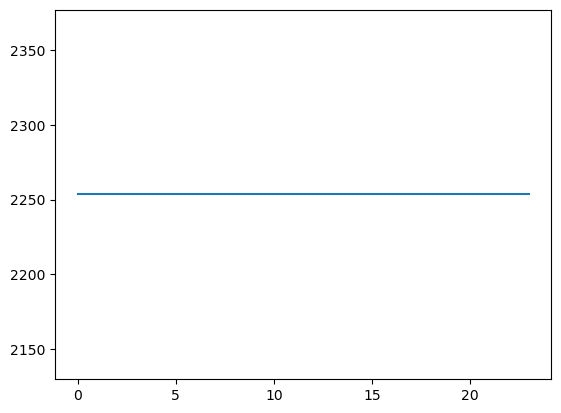

In [36]:
plt.plot(rho_updated)

In [ ]:
temp_updated[]